In [3]:
!uv add torch torchvision matplotlib tqdm

Resolved 70 packages in 12ms
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)--------------     0 B/76.70 KiB           
⠙ Preparing packages... (0/1)-------------- 16.00 KiB/76.70 KiB         
⠙ Preparing packages... (0/1)-------------- 32.00 KiB/76.70 KiB         
⠙ Preparing packages... (0/1)----------- 48.00 KiB/76.70 KiB         
⠙ Preparing packages... (0/1)---------- 64.00 KiB/76.70 KiB         
⠙ Preparing packages... (0/1)---------- 76.70 KiB/76.70 KiB         
Prepared 1 package in 70ms                                                   
Installed 1 package in 7ms                                  
 + tqdm==4.67.1


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

# Check if the current `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# is available, and if not, use the CPU
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Datasets

Train: 60000  |  Test: 10000
torch.Size([1, 28, 28])


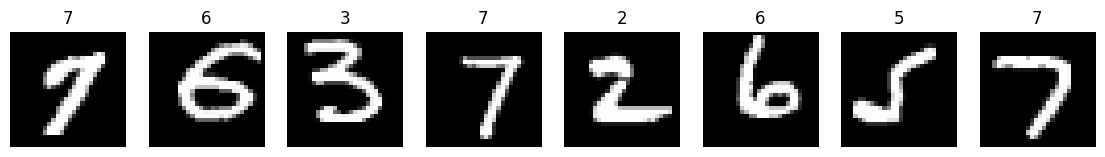

In [15]:
# from torch.utils.data import DataLoader
# # Chargement du dataset MINST
batch_size = 512
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(2/28, 2/28)),
    transforms.ToTensor()
])
test_transform  = transforms.Compose([transforms.ToTensor()])
train_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_MNIST = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)


trainloader_MNIST = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True)
testloader_MNIST  = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False)

# # # Vérification
print(f"Train: {len(train_MNIST)}  |  Test: {len(test_MNIST)}")

# # # Affichage d’un batch du train set
images_MNIST, labels_MNIST = next(iter(trainloader_MNIST))

fig, axs = plt.subplots(1, 8, figsize=(14, 2))
print(images_MNIST[0].size())
for i in range(8):
    axs[i].imshow(images_MNIST[i][0], cmap='gray')  # select channel 0
    axs[i].set_title(str(labels_MNIST[i].item()))
    axs[i].axis('off')

plt.show()




In [16]:
# Below we are preprocessing data for CIFAR-100. We use an arbitrary batch size of 128.
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tf_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])
test_tf_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

# Loading the CIFAR-100 dataset:
train_dataset_cifar = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_tf_cifar)
test_dataset_cifar = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_tf_cifar)

print(f"Number of training samples: {len(train_dataset_cifar)}")
print(f"Number of test samples: {len(test_dataset_cifar)}")

dataset_name = "CIFAR100"

#Dataloaders
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=batch_size, shuffle=False, num_workers=2)

Number of training samples: 50000
Number of test samples: 10000


# Train/Eval

In [7]:
from torch.nn import Module

def apply_max_norm(model, r=3.0):
    with torch.no_grad():
        for name, p in model.named_parameters():
            # Only Linear weights: [out_features, in_features]
            if 'weight' in name and p.dim() == 2:
                norms = p.norm(2, dim=1, keepdim=True)          # per-unit (row) L2
                desired = torch.clamp(norms, max=r)
                p.mul_(desired / (1e-8 + norms))

def train_epoch(model: Module, loader: DataLoader, optimizer: optim.Optimizer, device, regularization: float = 0.0):
    criterion = nn.CrossEntropyLoss()    
    model.train()
    running_loss = 0.0
    training_acc = 0
    total = 0
    for x,y in tqdm(loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        if regularization > 0.0:
            apply_max_norm(model, r=regularization)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        training_acc += (predicted == y).sum().item()

        

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * training_acc / total
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc




In [8]:
def evaluate(model: Module, loader: DataLoader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    running_loss = 0.0
    correct = 0
    # errors = np.zeros(10, dtype=int)
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            outputs = model(x)

            _, preds = torch.max(outputs.data, dim=1)


            loss = criterion(outputs, y)
            running_loss += loss.item()
            correct += (preds == y).sum().item()
            wrong_mask = preds.cpu().numpy() != y.cpu().numpy()

            # Count how many times each true label was misclassified
            # np.add.at(errors, y.cpu().numpy()[wrong_mask], 1)
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    # print(f"Test Errors: {errors}, Total: {errors.sum()}")
    return accuracy

# MLP (Reproduction of Distilling the Knowledge in a Neural Network by Hinton et al.)

In [9]:
class TeacherMLP(nn.Module):
    def __init__(self):
        super(TeacherMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 1200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1200, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x
    
class StudentMLP(nn.Module):
    def __init__(self):
        super(StudentMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [111]:
torch.manual_seed(42)
mlp_teacher = TeacherMLP().to(device)
teacher_mlp_loss_history = []
teacher_mlp_accuracy_history = []

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    loss, acc = train_epoch(mlp_teacher, trainloader_MNIST, learning_rate=0.001, device=device, regularization=3.0)
    teacher_mlp_loss_history.append(loss)
    teacher_mlp_accuracy_history.append(acc)

evaluate(mlp_teacher, testloader_MNIST, device)

Epoch 1
Training Loss: 0.4342, Training Accuracy: 86.52%
Epoch 2
Training Loss: 0.2126, Training Accuracy: 93.50%
Epoch 3
Training Loss: 0.1775, Training Accuracy: 94.61%
Epoch 4
Training Loss: 0.1601, Training Accuracy: 95.23%
Epoch 5
Training Loss: 0.1516, Training Accuracy: 95.51%
Epoch 6
Training Loss: 0.1458, Training Accuracy: 95.65%
Epoch 7
Training Loss: 0.1425, Training Accuracy: 95.92%
Epoch 8
Training Loss: 0.1414, Training Accuracy: 96.06%
Epoch 9
Training Loss: 0.1411, Training Accuracy: 96.05%
Epoch 10
Training Loss: 0.1396, Training Accuracy: 96.17%
Test Accuracy: 98.47%
Test Errors: [ 8  6 13 15  7 11 17 19 26 31], Total: 153


(98.47, array([ 8,  6, 13, 15,  7, 11, 17, 19, 26, 31]))

In [112]:
torch.manual_seed(42)
mlp_student = StudentMLP().to(device)
torch.manual_seed(42)
mlp_student_kd = StudentMLP().to(device)
student_mlp_loss_history = []
student_mlp_accuracy_history = []

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    loss, acc = train_epoch(mlp_student, trainloader_MNIST, learning_rate=0.001, device=device, regularization=3.0)
    student_mlp_loss_history.append(loss)
    student_mlp_accuracy_history.append(acc)

evaluate(mlp_student, testloader_MNIST, device)

Epoch 1
Training Loss: 0.3548, Training Accuracy: 88.96%
Epoch 2
Training Loss: 0.1337, Training Accuracy: 95.90%
Epoch 3
Training Loss: 0.1037, Training Accuracy: 96.78%
Epoch 4
Training Loss: 0.0886, Training Accuracy: 97.25%
Epoch 5
Training Loss: 0.0783, Training Accuracy: 97.58%
Epoch 6
Training Loss: 0.0732, Training Accuracy: 97.76%
Epoch 7
Training Loss: 0.0656, Training Accuracy: 97.97%
Epoch 8
Training Loss: 0.0630, Training Accuracy: 98.12%
Epoch 9
Training Loss: 0.0571, Training Accuracy: 98.25%
Epoch 10
Training Loss: 0.0554, Training Accuracy: 98.27%
Test Accuracy: 98.82%
Test Errors: [ 1  2 10  6 11 21 12 18 14 23], Total: 118


(98.82, array([ 1,  2, 10,  6, 11, 21, 12, 18, 14, 23]))

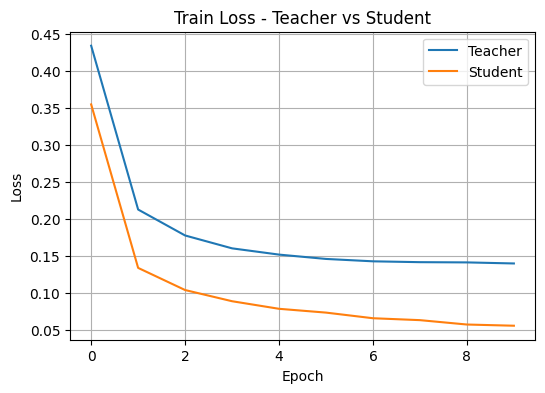

In [113]:
import matplotlib.pyplot as plt

# --- FIGURE 1 : Train Loss - MLP vs CNN ---
print
plt.figure(figsize=(6,4))
plt.plot(teacher_mlp_loss_history, label='Teacher')
plt.plot(student_mlp_loss_history, label='Student')
plt.title('Train Loss - Teacher vs Student')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# CNN 

### Teacher

In [10]:
import torch
import torch.nn as nn

class CIFAR100Teacher(nn.Module):
    """
    32x32 input → (2xConv+BN+ReLU) → MaxPool → (x3 stages)
    Channels: 64 → 128 → 256
    Output: Flatten(256*4*4) -> FC(1024) -> FC(100)
    """
    def __init__(self, num_classes=100, dropout_p=0.5):
        super().__init__()
        def conv3(in_c, out_c):
            # bias=False because BN has affine parameters
            return nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential(
            # Stage 1: 3x32x32 -> 64x32x32 -> 64x32x32 -> 64x16x16
            conv3(3, 64), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            conv3(64, 64), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Stage 2: 64x16x16 -> 128x16x16 -> 128x16x16 -> 128x8x8
            conv3(64, 128), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            conv3(128, 128), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Stage 3: 128x8x8 -> 256x8x8 -> 256x8x8 -> 256x4x4
            conv3(128, 256), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            conv3(256, 256), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 256x4x4 
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(1024, num_classes),
        )

        # self.apply(self._init_weights)

    # @staticmethod
    # def _init_weights(m):
    #     if isinstance(m, nn.Conv2d):
    #         nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
    #     elif isinstance(m, nn.BatchNorm2d):
    #         nn.init.ones_(m.weight)
    #         nn.init.zeros_(m.bias)
    #     elif isinstance(m, nn.Linear):
    #         nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
    #         if m.bias is not None:
    #             nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)          # B, 256*4*4 = 4096
        x = self.classifier(x)           # logits
        return x


In [25]:
from pathlib import Path
torch.manual_seed(42)
nn_teacher = CIFAR100Teacher(num_classes=100).to(device)
teacher_loss_history = []
teacher_accuracy_history = []
learning_rate=0.001
optimizer = optim.Adam(nn_teacher.parameters(), lr=learning_rate)

#If model exists, load weights else train
if Path(f'./model/CIFAR100/teacher_model_{dataset_name}.pth').exists():
    nn_teacher.load_state_dict(torch.load(f'./model/CIFAR100/teacher_model_{dataset_name}.pth'))
    print("Loaded pre-trained teacher model.")
else:
    for epoch in range(600):
        print(f"Epoch {epoch + 1}")
        loss, acc = train_epoch(nn_teacher, train_loader_cifar, optimizer, device=device)
        teacher_loss_history.append(loss)
        teacher_accuracy_history.append(acc)

        #Save the model every 30 epochs
        if (epoch + 1) % 30 == 0:
            torch.save(nn_teacher.state_dict(), f'./model/CIFAR100/teacher_model_{dataset_name}_epoch_{epoch + 1}.pth')
            evaluate(nn_teacher, test_loader_cifar, device)

test_accuracy_teacher = evaluate(nn_teacher, test_loader_cifar, device)
torch.save(nn_teacher.state_dict(), f'./model/CIFAR100/teacher_model_{dataset_name}.pth')

Loaded pre-trained teacher model.
Test Accuracy: 69.33%


### Student

In [26]:
import torch
import torch.nn as nn

class CIFAR100Student(nn.Module):
    def __init__(self, num_classes=100, dropout_p=0.2):
        super().__init__()
        def conv3(in_c, out_c):
            return nn.Conv2d(in_c, out_c, 3, padding=1, bias=False)

        self.features = nn.Sequential(
            conv3(3, 16),  nn.BatchNorm2d(16),  nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            conv3(16, 32), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8

            conv3(32, 64), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8 -> 4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(64 * 4 * 4, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [27]:
from pathlib import Path
torch.manual_seed(42)
nn_student = CIFAR100Student(num_classes=100).to(device)
torch.manual_seed(42)
nn_student_distillation = CIFAR100Student(num_classes=100).to(device)
optimizer = optim.Adam(nn_student.parameters(), lr=learning_rate)


# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_student:", torch.norm(nn_student.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of nn_student_distillation:", torch.norm(nn_student_distillation.features[0].weight).item())

total_params_teacher = "{:,}".format(sum(p.numel() for p in nn_teacher.parameters()))
print(f"TeacherNN parameters: {total_params_teacher}")
total_params_student = "{:,}".format(sum(p.numel() for p in nn_student.parameters()))
print(f"StudentNN parameters: {total_params_student}")


student_loss_history = []
student_accuracy_history = []

#If model exists, load weights else train
if Path(f'./model/CIFAR100/student_model_{dataset_name}.pth').exists():
    nn_student.load_state_dict(torch.load(f'./model/CIFAR100/student_model_{dataset_name}.pth'))
    print("Loaded pre-trained student model.")
else:
    for epoch in range(100):
        print(f"Epoch {epoch + 1}")
        loss, acc = train_epoch(nn_student, train_loader_cifar, optimizer, device=device)
        student_loss_history.append(loss)
        student_accuracy_history.append(acc)
        
        if (epoch + 1) % 10 == 0:
            torch.save(nn_student.state_dict(), f'./model/CIFAR100/student_model_{dataset_name}_epoch_{epoch + 1}.pth')
            evaluate(nn_student, test_loader_cifar, device)

test_accuracy_student = evaluate(nn_student, test_loader_cifar, device)

Norm of 1st layer of nn_student: 2.327361822128296
Norm of 1st layer of nn_student_distillation: 2.327361822128296
TeacherNN parameters: 5,444,132
StudentNN parameters: 95,796
Epoch 1


  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [00:06<00:00, 14.35it/s]


Training Loss: 4.3360, Training Accuracy: 4.28%
Epoch 2


100%|██████████| 98/98 [00:06<00:00, 14.26it/s]


Training Loss: 3.8809, Training Accuracy: 9.94%
Epoch 3


100%|██████████| 98/98 [00:06<00:00, 15.33it/s]


Training Loss: 3.6461, Training Accuracy: 13.05%
Epoch 4


100%|██████████| 98/98 [00:06<00:00, 14.96it/s]


Training Loss: 3.4910, Training Accuracy: 15.52%
Epoch 5


100%|██████████| 98/98 [00:06<00:00, 15.44it/s]


Training Loss: 3.3795, Training Accuracy: 17.53%
Epoch 6


100%|██████████| 98/98 [00:07<00:00, 12.68it/s]


Training Loss: 3.2968, Training Accuracy: 18.75%
Epoch 7


100%|██████████| 98/98 [00:08<00:00, 11.46it/s]


Training Loss: 3.2282, Training Accuracy: 20.03%
Epoch 8


100%|██████████| 98/98 [00:08<00:00, 12.05it/s]


Training Loss: 3.1822, Training Accuracy: 20.69%
Epoch 9


100%|██████████| 98/98 [00:07<00:00, 12.27it/s]


Training Loss: 3.1455, Training Accuracy: 21.55%
Epoch 10


100%|██████████| 98/98 [00:06<00:00, 14.06it/s]


Training Loss: 3.1183, Training Accuracy: 22.00%
Epoch 11


100%|██████████| 98/98 [00:07<00:00, 12.83it/s]


Training Loss: 3.0822, Training Accuracy: 22.93%
Epoch 12


100%|██████████| 98/98 [00:07<00:00, 13.78it/s]


Training Loss: 3.0654, Training Accuracy: 22.99%
Epoch 13


100%|██████████| 98/98 [00:07<00:00, 13.34it/s]


Training Loss: 3.0292, Training Accuracy: 23.76%
Epoch 14


100%|██████████| 98/98 [00:07<00:00, 12.80it/s]


Training Loss: 3.0127, Training Accuracy: 23.90%
Epoch 15


100%|██████████| 98/98 [00:07<00:00, 13.16it/s]


Training Loss: 2.9940, Training Accuracy: 24.21%
Epoch 16


100%|██████████| 98/98 [00:07<00:00, 13.14it/s]


Training Loss: 2.9714, Training Accuracy: 24.74%
Epoch 17


100%|██████████| 98/98 [00:07<00:00, 13.32it/s]


Training Loss: 2.9611, Training Accuracy: 24.69%
Epoch 18


100%|██████████| 98/98 [00:07<00:00, 13.46it/s]


Training Loss: 2.9491, Training Accuracy: 25.29%
Epoch 19


100%|██████████| 98/98 [00:07<00:00, 13.67it/s]


Training Loss: 2.9338, Training Accuracy: 25.49%
Epoch 20


100%|██████████| 98/98 [00:07<00:00, 12.26it/s]


Training Loss: 2.9231, Training Accuracy: 25.66%
Epoch 21


100%|██████████| 98/98 [00:06<00:00, 14.43it/s]


Training Loss: 2.9114, Training Accuracy: 25.83%
Epoch 22


100%|██████████| 98/98 [00:06<00:00, 14.31it/s]


Training Loss: 2.8896, Training Accuracy: 26.40%
Epoch 23


100%|██████████| 98/98 [00:06<00:00, 14.11it/s]


Training Loss: 2.8828, Training Accuracy: 26.53%
Epoch 24


100%|██████████| 98/98 [00:06<00:00, 15.77it/s]


Training Loss: 2.8736, Training Accuracy: 26.44%
Epoch 25


100%|██████████| 98/98 [00:06<00:00, 15.19it/s]


Training Loss: 2.8570, Training Accuracy: 26.88%
Epoch 26


100%|██████████| 98/98 [00:06<00:00, 14.11it/s]


Training Loss: 2.8528, Training Accuracy: 26.72%
Epoch 27


100%|██████████| 98/98 [00:07<00:00, 13.99it/s]


Training Loss: 2.8480, Training Accuracy: 27.03%
Epoch 28


100%|██████████| 98/98 [00:06<00:00, 14.18it/s]


Training Loss: 2.8346, Training Accuracy: 27.31%
Epoch 29


100%|██████████| 98/98 [00:07<00:00, 13.76it/s]


Training Loss: 2.8223, Training Accuracy: 27.55%
Epoch 30


100%|██████████| 98/98 [00:07<00:00, 13.57it/s]


Training Loss: 2.8231, Training Accuracy: 27.45%
Epoch 31


100%|██████████| 98/98 [00:06<00:00, 14.07it/s]


Training Loss: 2.8096, Training Accuracy: 27.88%
Epoch 32


100%|██████████| 98/98 [00:06<00:00, 14.02it/s]


Training Loss: 2.7959, Training Accuracy: 28.16%
Epoch 33


100%|██████████| 98/98 [00:07<00:00, 12.87it/s]


Training Loss: 2.7960, Training Accuracy: 28.17%
Epoch 34


100%|██████████| 98/98 [00:06<00:00, 14.05it/s]


Training Loss: 2.7897, Training Accuracy: 28.29%
Epoch 35


100%|██████████| 98/98 [00:07<00:00, 13.55it/s]


Training Loss: 2.7790, Training Accuracy: 28.32%
Epoch 36


100%|██████████| 98/98 [00:06<00:00, 14.06it/s]


Training Loss: 2.7727, Training Accuracy: 28.43%
Epoch 37


100%|██████████| 98/98 [00:06<00:00, 14.40it/s]


Training Loss: 2.7592, Training Accuracy: 28.77%
Epoch 38


100%|██████████| 98/98 [00:07<00:00, 13.84it/s]


Training Loss: 2.7513, Training Accuracy: 28.80%
Epoch 39


100%|██████████| 98/98 [00:06<00:00, 15.24it/s]


Training Loss: 2.7409, Training Accuracy: 29.16%
Epoch 40


100%|██████████| 98/98 [00:06<00:00, 14.38it/s]


Training Loss: 2.7313, Training Accuracy: 29.29%
Epoch 41


100%|██████████| 98/98 [00:06<00:00, 14.26it/s]


Training Loss: 2.7247, Training Accuracy: 29.59%
Epoch 42


100%|██████████| 98/98 [00:06<00:00, 14.12it/s]


Training Loss: 2.7250, Training Accuracy: 29.69%
Epoch 43


100%|██████████| 98/98 [00:06<00:00, 14.34it/s]


Training Loss: 2.7130, Training Accuracy: 29.73%
Epoch 44


100%|██████████| 98/98 [00:06<00:00, 14.38it/s]


Training Loss: 2.7052, Training Accuracy: 29.73%
Epoch 45


100%|██████████| 98/98 [00:06<00:00, 14.93it/s]


Training Loss: 2.7080, Training Accuracy: 29.72%
Epoch 46


100%|██████████| 98/98 [00:06<00:00, 16.24it/s]


Training Loss: 2.6940, Training Accuracy: 30.16%
Epoch 47


100%|██████████| 98/98 [00:06<00:00, 15.70it/s]


Training Loss: 2.6947, Training Accuracy: 30.18%
Epoch 48


100%|██████████| 98/98 [00:06<00:00, 14.94it/s]


Training Loss: 2.6934, Training Accuracy: 30.12%
Epoch 49


100%|██████████| 98/98 [00:06<00:00, 14.95it/s]


Training Loss: 2.6775, Training Accuracy: 30.47%
Epoch 50


100%|██████████| 98/98 [00:06<00:00, 15.30it/s]


Training Loss: 2.6824, Training Accuracy: 30.12%
Epoch 51


100%|██████████| 98/98 [00:07<00:00, 13.88it/s]


Training Loss: 2.6712, Training Accuracy: 30.51%
Epoch 52


100%|██████████| 98/98 [00:06<00:00, 15.32it/s]


Training Loss: 2.6735, Training Accuracy: 30.44%
Epoch 53


100%|██████████| 98/98 [00:07<00:00, 13.18it/s]


Training Loss: 2.6587, Training Accuracy: 30.85%
Epoch 54


100%|██████████| 98/98 [00:06<00:00, 15.13it/s]


Training Loss: 2.6517, Training Accuracy: 30.93%
Epoch 55


100%|██████████| 98/98 [00:06<00:00, 14.65it/s]


Training Loss: 2.6489, Training Accuracy: 30.77%
Epoch 56


100%|██████████| 98/98 [00:06<00:00, 15.18it/s]


Training Loss: 2.6376, Training Accuracy: 31.22%
Epoch 57


100%|██████████| 98/98 [00:06<00:00, 14.55it/s]


Training Loss: 2.6362, Training Accuracy: 31.13%
Epoch 58


100%|██████████| 98/98 [00:06<00:00, 15.36it/s]


Training Loss: 2.6385, Training Accuracy: 31.29%
Epoch 59


100%|██████████| 98/98 [00:06<00:00, 15.59it/s]


Training Loss: 2.6265, Training Accuracy: 31.51%
Epoch 60


100%|██████████| 98/98 [00:06<00:00, 14.97it/s]


Training Loss: 2.6224, Training Accuracy: 31.37%
Epoch 61


100%|██████████| 98/98 [00:06<00:00, 15.29it/s]


Training Loss: 2.6231, Training Accuracy: 31.50%
Epoch 62


100%|██████████| 98/98 [00:06<00:00, 14.75it/s]


Training Loss: 2.6224, Training Accuracy: 31.49%
Epoch 63


100%|██████████| 98/98 [00:06<00:00, 14.40it/s]


Training Loss: 2.6180, Training Accuracy: 31.43%
Epoch 64


100%|██████████| 98/98 [00:06<00:00, 14.20it/s]


Training Loss: 2.6068, Training Accuracy: 32.02%
Epoch 65


100%|██████████| 98/98 [00:06<00:00, 14.31it/s]


Training Loss: 2.6002, Training Accuracy: 31.82%
Epoch 66


100%|██████████| 98/98 [00:06<00:00, 15.72it/s]


Training Loss: 2.5939, Training Accuracy: 32.11%
Epoch 67


100%|██████████| 98/98 [00:06<00:00, 15.66it/s]


Training Loss: 2.5882, Training Accuracy: 32.06%
Epoch 68


100%|██████████| 98/98 [00:06<00:00, 14.96it/s]


Training Loss: 2.5902, Training Accuracy: 32.31%
Epoch 69


100%|██████████| 98/98 [00:06<00:00, 15.35it/s]


Training Loss: 2.5906, Training Accuracy: 32.23%
Epoch 70


100%|██████████| 98/98 [00:06<00:00, 15.59it/s]


Training Loss: 2.5818, Training Accuracy: 32.21%
Epoch 71


100%|██████████| 98/98 [00:06<00:00, 15.04it/s]


Training Loss: 2.5809, Training Accuracy: 32.23%
Epoch 72


100%|██████████| 98/98 [00:06<00:00, 15.72it/s]


Training Loss: 2.5777, Training Accuracy: 32.55%
Epoch 73


100%|██████████| 98/98 [00:06<00:00, 15.66it/s]


Training Loss: 2.5781, Training Accuracy: 32.65%
Epoch 74


100%|██████████| 98/98 [00:06<00:00, 16.00it/s]


Training Loss: 2.5648, Training Accuracy: 32.70%
Epoch 75


100%|██████████| 98/98 [00:06<00:00, 15.06it/s]


Training Loss: 2.5591, Training Accuracy: 32.59%
Epoch 76


100%|██████████| 98/98 [00:06<00:00, 15.15it/s]


Training Loss: 2.5675, Training Accuracy: 33.02%
Epoch 77


100%|██████████| 98/98 [00:06<00:00, 15.53it/s]


Training Loss: 2.5572, Training Accuracy: 32.77%
Epoch 78


100%|██████████| 98/98 [00:06<00:00, 15.04it/s]


Training Loss: 2.5532, Training Accuracy: 32.64%
Epoch 79


100%|██████████| 98/98 [00:06<00:00, 14.33it/s]


Training Loss: 2.5553, Training Accuracy: 32.80%
Epoch 80


100%|██████████| 98/98 [00:06<00:00, 15.12it/s]


Training Loss: 2.5497, Training Accuracy: 33.12%
Epoch 81


100%|██████████| 98/98 [00:06<00:00, 15.27it/s]


Training Loss: 2.5398, Training Accuracy: 33.25%
Epoch 82


100%|██████████| 98/98 [00:06<00:00, 15.77it/s]


Training Loss: 2.5450, Training Accuracy: 33.25%
Epoch 83


100%|██████████| 98/98 [00:06<00:00, 15.39it/s]


Training Loss: 2.5514, Training Accuracy: 32.81%
Epoch 84


100%|██████████| 98/98 [00:06<00:00, 15.20it/s]


Training Loss: 2.5368, Training Accuracy: 33.15%
Epoch 85


100%|██████████| 98/98 [00:06<00:00, 15.40it/s]


Training Loss: 2.5288, Training Accuracy: 33.71%
Epoch 86


100%|██████████| 98/98 [00:06<00:00, 15.33it/s]


Training Loss: 2.5349, Training Accuracy: 33.20%
Epoch 87


100%|██████████| 98/98 [00:06<00:00, 16.15it/s]


Training Loss: 2.5276, Training Accuracy: 33.39%
Epoch 88


100%|██████████| 98/98 [00:06<00:00, 16.15it/s]


Training Loss: 2.5287, Training Accuracy: 33.46%
Epoch 89


100%|██████████| 98/98 [00:06<00:00, 15.96it/s]


Training Loss: 2.5214, Training Accuracy: 33.72%
Epoch 90


100%|██████████| 98/98 [00:06<00:00, 15.16it/s]


Training Loss: 2.5228, Training Accuracy: 33.53%
Epoch 91


100%|██████████| 98/98 [00:06<00:00, 15.50it/s]


Training Loss: 2.5114, Training Accuracy: 33.91%
Epoch 92


100%|██████████| 98/98 [00:06<00:00, 16.08it/s]


Training Loss: 2.4957, Training Accuracy: 34.14%
Epoch 93


100%|██████████| 98/98 [00:06<00:00, 16.03it/s]


Training Loss: 2.4953, Training Accuracy: 34.45%
Epoch 94


100%|██████████| 98/98 [00:06<00:00, 16.30it/s]


Training Loss: 2.4933, Training Accuracy: 34.38%
Epoch 95


100%|██████████| 98/98 [00:06<00:00, 14.17it/s]


Training Loss: 2.4912, Training Accuracy: 34.29%
Epoch 96


100%|██████████| 98/98 [00:06<00:00, 15.90it/s]


Training Loss: 2.4883, Training Accuracy: 34.32%
Epoch 97


100%|██████████| 98/98 [00:07<00:00, 13.95it/s]


Training Loss: 2.4745, Training Accuracy: 34.66%
Epoch 98


100%|██████████| 98/98 [00:06<00:00, 14.69it/s]


Training Loss: 2.4834, Training Accuracy: 34.50%
Epoch 99


100%|██████████| 98/98 [00:06<00:00, 15.37it/s]


Training Loss: 2.4779, Training Accuracy: 34.52%
Epoch 100


100%|██████████| 98/98 [00:06<00:00, 15.43it/s]

Training Loss: 2.4652, Training Accuracy: 35.16%


Test Accuracy: 44.13%


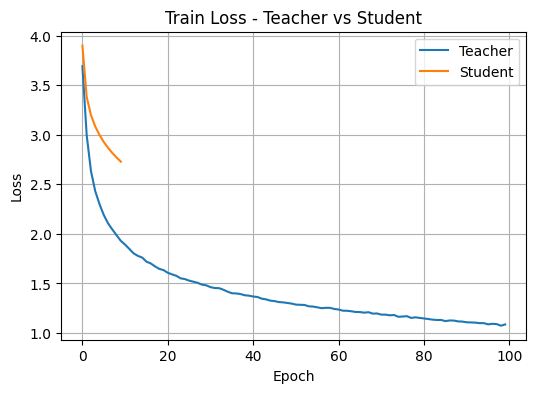

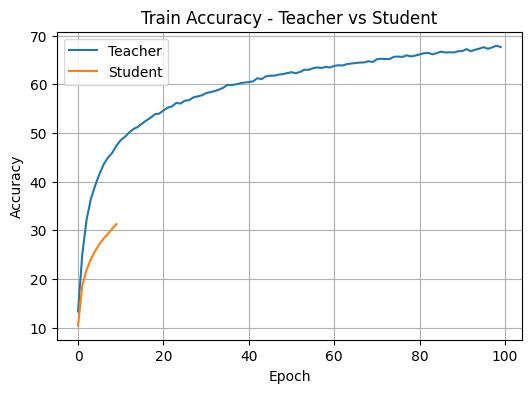

In [ ]:
import matplotlib.pyplot as plt

# --- FIGURE 1 : Train Loss - MLP vs CNN ---
print
plt.figure(figsize=(6,4))
plt.plot(teacher_loss_history, label='Teacher')
plt.plot(student_loss_history, label='Student')
plt.title('Train Loss - Teacher vs Student')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- FIGURE 2 : Test Accuracy - MLP vs CNN ---
plt.figure(figsize=(6,4))
plt.plot(teacher_accuracy_history, label='Teacher')
plt.plot(student_accuracy_history, label='Student')
plt.title('Train Accuracy - Teacher vs Student')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Distillation Code

In [33]:

def distillation_training(
        teacher: Module, 
        student: Module,
        loader: DataLoader, 
        optimizer: optim.Optimizer, 
        device, 
        temperature: float = 5.0, 
        alpha : float = 0.7):
    '''
        1. Compute teacher predictions with torch.no_grad() and apply softmax(logits / T) to obtain soft targets (p_t).
        2. Compute student logits, then log_softmax(logits / T) for the soft loss term (p_s). (Because KL Divergence is sum(p_t * log(p_t/p_s)) )
        3. Compute the soft-target objective: KLDiv between teacher soft targets (p_t) and student predictions (p_s),
            using the same temperature T on both sides.
        4. Compute the label objective: standard CrossEntropy between raw student logits (T=1) and ground-truth labels (y_true).
        5. Combine both losses: total_loss = soft_target_weight * (T^2) * soft_loss + label_objective_weight * hard_loss
            weights control the balance and T^2 compensates for gradient scaling.
        6. Backpropagate total_loss and update only the student parameters.
        7. Compute and track accuracy using student logits at T=1.
    '''

    label_loss = nn.CrossEntropyLoss()
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    
    teacher.eval()
    student.train()

    running_loss = 0.0
    training_acc = 0
    total = 0
    for inputs, label in tqdm(loader):
        inputs, label = inputs.to(device), label.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = teacher(inputs)
        student_logits = student(inputs)
        

        teacher_soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_logits / temperature, dim=1)

        soft_target_loss = kl_loss(student_log_probs, teacher_soft_targets) * (temperature ** 2)
        hard_loss = label_loss(student_logits, label)

        total_loss = (alpha * soft_target_loss) + ((1 - alpha) * hard_loss)

        total_loss.backward()
        optimizer.step()
        

        running_loss += total_loss.item()
        pred = student_logits.argmax(1)
        total += label.size(0)
        training_acc += (pred == label).sum().item()

        

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * training_acc / total
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

In [ ]:
nn_student_distillation = CIFAR100Student(num_classes=100).to(device)
optimizer = optim.SGD(nn_student_distillation.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

for epoch in range(100):
    print(f"Epoch {epoch + 1}")
    loss, acc = distillation_training(
        teacher=nn_teacher,
        student=nn_student_distillation,
        loader=train_loader_cifar,
        optimizer=optimizer,
        device=device,
        temperature=3.0,
        alpha=0.25
    )
    student_loss_history.append(loss)
    student_accuracy_history.append(acc)

    if (epoch + 1) % 10 == 0:
        torch.save(nn_student_distillation.state_dict(), f'./model/CIFAR100/student_model_distillation_{dataset_name}_epoch_{epoch + 1}.pth')
        evaluate(nn_student_distillation, test_loader_cifar, device)
test_accuracy_student_distillation = evaluate(nn_student_distillation, test_loader_cifar, device)

Epoch 1


100%|██████████| 98/98 [00:06<00:00, 14.62it/s]


Training Loss: 6.1454, Training Accuracy: 39.50%
Epoch 2


100%|██████████| 98/98 [00:07<00:00, 13.60it/s]


Training Loss: 6.0788, Training Accuracy: 39.95%
Epoch 3


100%|██████████| 98/98 [00:06<00:00, 14.41it/s]


Training Loss: 6.1001, Training Accuracy: 39.90%
Epoch 4


100%|██████████| 98/98 [00:06<00:00, 15.16it/s]


Training Loss: 6.0993, Training Accuracy: 39.64%
Epoch 5


100%|██████████| 98/98 [00:06<00:00, 14.57it/s]


Training Loss: 6.0520, Training Accuracy: 40.12%
Epoch 6


 77%|███████▋  | 75/98 [00:05<00:02, 11.43it/s]